In [1]:
%matplotlib inline

In [2]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

stop_words = set(stopwords.words('english'))

Using TensorFlow backend.


In [3]:
data = pd.read_csv("sub.csv")
data.head()
sentiment = data["rating"] >3
sentiment = sentiment.astype(int)
#Prepare model data
model_data = pd.DataFrame({"MaxTrait":data["MaxTrait"],"text": data["text"], "sentiment":sentiment})
model_data.head()

,MaxTrait,text,sentiment
0,Cat,GOOD LOOKING KICKS IF YOUR KICKIN IT OLD SCHOO...,1
1,Cat,These sunglasses are all right. They were a li...,1
2,Cat,I don't see the difference between these bodys...,1
3,Cat,Very nice basic clothing. I think the size is ...,1
4,Cat,I love these socks. They fit great (my 15 mont...,1


In [4]:
def remove_pun(element):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return element.translate(translator)
def remove_stopwords(element):
    element = [word.lower() for word in element.split() if word.lower() not in stop_words]
    return " ".join(element)

In [5]:
model_data["text"] = model_data["text"].apply(remove_pun)
model_data["text"] = model_data["text"].apply(remove_stopwords)
model_data.head()

,MaxTrait,text,sentiment
0,Cat,good looking kicks kickin old school like comf...,1
1,Cat,sunglasses right little crooked still cool,1
2,Cat,dont see difference bodysuits expensive ones f...,1
3,Cat,nice basic clothing think size fine really lik...,1
4,Cat,love socks fit great 15 month old daughter thi...,1


In [6]:
#normalize personality
per = np.unique(model_data["MaxTrait"])
nor = [i+1 for i in range(per.shape[0])]
nor_map = dict(zip(per, nor))
model_data["MaxTrait"] = model_data["MaxTrait"].map(nor_map)
model_data["MaxTrait"] = model_data["MaxTrait"]/5
model_data.head()

,MaxTrait,text,sentiment
0,0.2,good looking kicks kickin old school like comf...,1
1,0.2,sunglasses right little crooked still cool,1
2,0.2,dont see difference bodysuits expensive ones f...,1
3,0.2,nice basic clothing think size fine really lik...,1
4,0.2,love socks fit great 15 month old daughter thi...,1


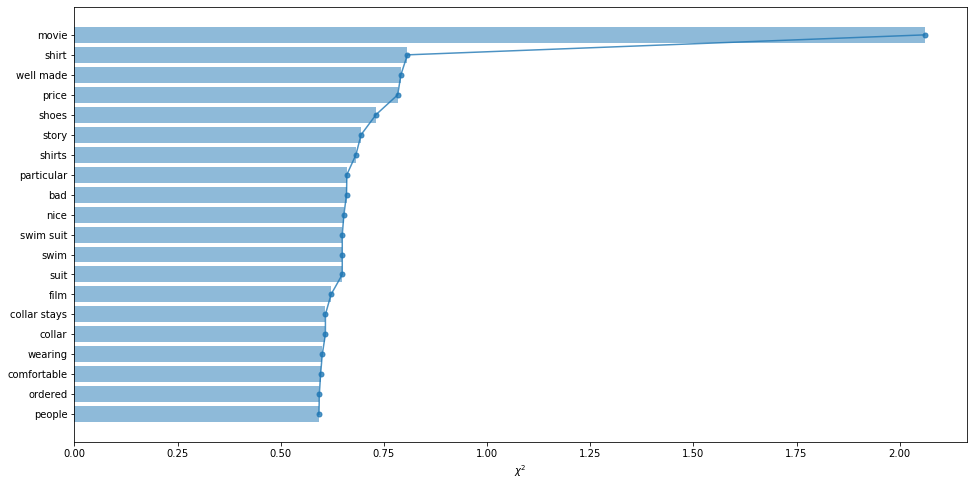

In [7]:
#feature checking
tfidf = TfidfVectorizer(max_features = 30000, ngram_range = (1,3))
x_tfidf = tfidf.fit_transform(model_data.text)
y = model_data.sentiment
chi2score = chi2(x_tfidf, y)[0]
plt.figure(figsize=(16,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

In [8]:
#for element in x_tfidf:
#    print(element)
#tfidf result document id, token id, tfidf_score

In [21]:
#LSTM no personality
max_len = 200
tokenizer = Tokenizer(num_words = max_len, split = " ")
tokenizer.fit_on_texts(model_data["text"].values)
x = tokenizer.texts_to_sequences(model_data["text"].values)
x = pad_sequences(x)
y = pd.get_dummies(model_data["sentiment"]).values
x_train, x_test, y_train, y_test = train_test_split(x, y,train_size = 0.8, random_state = 13)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape) 

(64, 208) (64, 2)
(16, 208) (16, 2)


In [22]:
#Build LSTM model
embed_dim = 150
lstm_out = 200
model = Sequential()
model.add(Embedding(max_len, embed_dim,input_length = x.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 208, 150)          30000     
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               280800    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402       
Total params: 311,202
Trainable params: 311,202
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
#Train model
batch_size = 32
model.fit(x_train, y_train, epochs = 3, batch_size=batch_size, verbose = 2)

Epoch 1/3
 - 6s - loss: 0.6908 - acc: 0.6250
Epoch 2/3
 - 2s - loss: 0.6726 - acc: 0.8125
Epoch 3/3
 - 2s - loss: 0.6519 - acc: 0.8125


In [24]:
score,acc = model.evaluate(x_test, y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.65
acc: 0.75


In [25]:
#Initializing measure matrix
pos_count, neg_count, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(x_test)):   
    result = model.predict(x_test[x].reshape(1,x_test.shape[1]),batch_size=1,verbose = 2)[0]   
    if np.argmax(result) == np.argmax(y_test[x]):
        if np.argmax(y_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1       
    if np.argmax(y_test[x]) == 0:
        neg_count += 1
    else:
        pos_count += 1
pos_acc = pos_correct/pos_count
neg_acc = neg_correct/neg_count
g_mean = sqrt(pos_acc*neg_acc)
#save performance
accuracy = np.array(acc)
g_out = np.array(g_mean)
pos = np.array(pos_acc)
neg = np.array(neg_acc)

1.0
0.5555555555555556


In [26]:
#LSTM by personality
max_len = 200
tokenizer = Tokenizer(num_words = max_len, split = " ")
tokenizer.fit_on_texts(model_data["text"].values)
x = tokenizer.texts_to_sequences(model_data["text"].values)
x = pad_sequences(x)
y = pd.get_dummies(model_data["sentiment"]).values
x = pd.DataFrame(x)
x.insert(0, "MaxTrait", model_data["MaxTrait"])
x = x.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y,train_size = 0.8, random_state = 13)
#print(x_train.shape, y_train.shape)
#print(x_test.shape, y_test.shape) 

In [27]:
#Build LSTM model
embed_dim = 150
lstm_out = 200
model = Sequential()
model.add(Embedding(max_len, embed_dim,input_length = x.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 209, 150)          30000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 200)               280800    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params: 311,202
Trainable params: 311,202
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
batch_size = 32
model.fit(x_train, y_train, epochs = 3, batch_size=batch_size, verbose = 2)

Epoch 1/3
 - 6s - loss: 0.6925 - acc: 0.4844
Epoch 2/3
 - 2s - loss: 0.6737 - acc: 0.6719
Epoch 3/3
 - 2s - loss: 0.6529 - acc: 0.7656


In [29]:
score,acc = model.evaluate(x_test, y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.65
acc: 0.81


In [30]:
#Initializing measure matrix
pos_count, neg_count, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(x_test)):
    
    result = model.predict(x_test[x].reshape(1,x_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(y_test[x]):
        if np.argmax(y_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(y_test[x]) == 0:
        neg_count += 1
    else:
        pos_count += 1
pos_acc = pos_correct/pos_count
neg_acc = neg_correct/neg_count
g_mean = sqrt(pos_acc*neg_acc)
accuracy = np.append(accuracy, np.array(acc))
g_out = np.append(g_out,np.array(g_mean))
print(pos_acc)
print(neg_acc)
print(g_mean)
pos = np.append(pos,np.array(pos_acc))
neg = np.append(neg, np.array(neg_acc))

1.0
0.6666666666666666
0.816496580927726


In [31]:
print(accuracy)
print(g_out)
print(pos)
print(neg)

[0.75   0.8125]
[0.74535599 0.81649658]
[1. 1.]
[0.55555556 0.66666667]


In [32]:
output = pd.DataFrame({"accuracy":accuracy, "g_mean":g_out, "pos":pos, "neg":neg})

In [33]:
output.to_csv("lstmoutput.csv", index = False)